In [2]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

In [51]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

def save_traces_to_zstd(traces, output_path, dtype=np.float16, trace_shape=(54, 32768), compression_level=15):
    """
    Save a list of numpy arrays (traces) into a compressed Zstandard (.zst) file.
    """
    def shuffle_bytes(arr: np.ndarray) -> bytes:
        return arr.view(np.uint8).reshape(-1, arr.itemsize).T.tobytes()

    all_data = bytearray()
    for trace in traces:
        if trace.shape != trace_shape:
            raise ValueError(f"Trace has wrong shape {trace.shape}, expected {trace_shape}")
        shuffled = shuffle_bytes(trace.astype(dtype))
        all_data.extend(shuffled)

    compressor = zstd.ZstdCompressor(level=compression_level)
    compressed_data = compressor.compress(bytes(all_data))

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'wb') as f:
        f.write(compressed_data)

def load_traces_from_zstd(input_path, n_traces, dtype=np.float16, trace_shape=(54, 32768)) -> np.ndarray:
    """
    Load a list of numpy arrays (traces) from a compressed Zstandard (.zst) file and return a single stacked ndarray.
    """
    def unshuffle_bytes(data: bytes, dtype=np.float16, shape=(54, 32768)) -> np.ndarray:
        itemsize = np.dtype(dtype).itemsize
        num_elements = np.prod(shape)
        reshaped = np.frombuffer(data, dtype=np.uint8).reshape(itemsize, num_elements).T
        unshuffled = reshaped.reshape(-1)
        return unshuffled.view(dtype).reshape(shape)

    decompressor = zstd.ZstdDecompressor()
    with open(input_path, 'rb') as f:
        compressed_content = f.read()
        decompressed = decompressor.decompress(compressed_content)

    trace_size_bytes = np.prod(trace_shape) * np.dtype(dtype).itemsize
    expected_size = n_traces * trace_size_bytes
    if len(decompressed) != expected_size:
        raise ValueError("Decompressed size does not match expected size")

    traces = []
    for i in range(n_traces):
        start = i * trace_size_bytes
        end = start + trace_size_bytes
        trace_bytes = decompressed[start:end]
        trace = unshuffle_bytes(trace_bytes, dtype=dtype, shape=trace_shape)
        traces.append(trace)

    return np.stack(traces)

# Example usage (replace with actual TraceSimulator)
# ts = TraceSimulator(read_yaml_to_dict("config.yaml"))
# energy = 50
# n_sets = 100
# all_traces = []
# for _ in range(n_sets):
#     trace, _ = ts.generate(energy, type_recoil='NR', no_noise=False)
#     all_traces.append(np.asarray(trace, dtype=np.float16))
#
# save_traces_to_zstd(all_traces, f"compressed_traces/traces_energy_{energy}.zst")
# loaded_traces = load_traces_from_zstd(f"compressed_traces/traces_energy_{energy}.zst", n_traces=n_sets)


In [ ]:
energy = 0
n_sets = 2
all_traces = []
for _ in range(n_sets):
    trace = ts.generate(
        E=energy,
        x=-40, y=80, z=-1800,
        no_noise=False,
        type_recoil='NR',
        quantize=True,
        phonon_only=False
    )
    all_traces.append(np.asarray(trace[0], dtype=np.float16))

save_traces_to_zstd(all_traces, f"compressed_traces/traces_energy_{energy}.zst")
loaded_traces = load_traces_from_zstd(f"compressed_traces/traces_energy_{energy}.zst", n_traces=n_sets)


KeyboardInterrupt: 

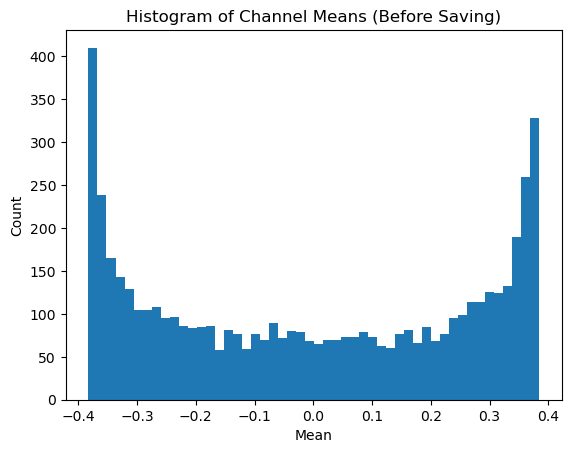

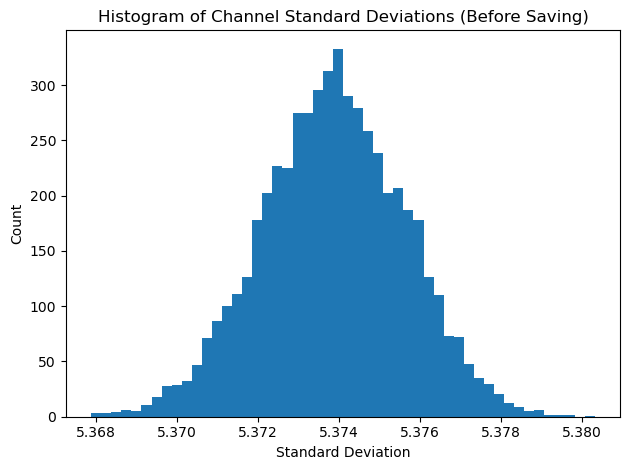

In [52]:
energy = 0
n_sets = 100
all_traces = []
all_means = []
all_stds = []

for _ in range(n_sets):
    trace = ts.generate(
        E=energy,
        x=-40, y=80, z=-1800,
        no_noise=False,
        type_recoil='NR',
        quantize=True,
        phonon_only=False
    ) # simulate single (1, 54, 32768) trace
    trace = np.asarray(trace[0], dtype=np.float16)  # shape: (54, 32768)
    all_traces.append(trace)

    # Convert to float32 for numerical stability in calculations
    trace_f32 = trace.astype(np.float32)
    means = trace_f32.mean(axis=-1)  # shape: (54,)
    stds = trace_f32.std(axis=-1)    # shape: (54,)

    all_means.extend(means)
    all_stds.extend(stds)


# Convert to numpy arrays for histogram plotting
all_means = np.array(all_means)
all_stds = np.array(all_stds)

# Plot histograms
fig1, ax1 = plt.subplots()
ax1.hist(all_means, bins=50)
ax1.set_title("Histogram of Channel Means (Before Saving)")
ax1.set_xlabel("Mean")
ax1.set_ylabel("Count")

fig2, ax2 = plt.subplots()
ax2.hist(all_stds, bins=50)
ax2.set_title("Histogram of Channel Standard Deviations (Before Saving)")
ax2.set_xlabel("Standard Deviation")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()


save_traces_to_zstd(all_traces, f"compressed_traces/traces_energy_{energy}.zst")
loaded_traces = load_traces_from_zstd(f"compressed_traces/traces_energy_{energy}.zst", n_traces=n_sets)

In [38]:
import matplotlib.pyplot as plt

def plot_trace_set(trace_set):
    """
    Plot all 54 channels of a single trace set (shape: (54, 32768))
    """
    
    fig, axs = plt.subplots(9, 6, figsize=(20, 10), sharex=True)
    axs = axs.flatten()
    for ch in range(54):
        axs[ch].plot(trace_set[ch])
        axs[ch].set_title(f'Ch {ch}')
    plt.tight_layout()
    plt.show()


--- Trace Set 0 ---


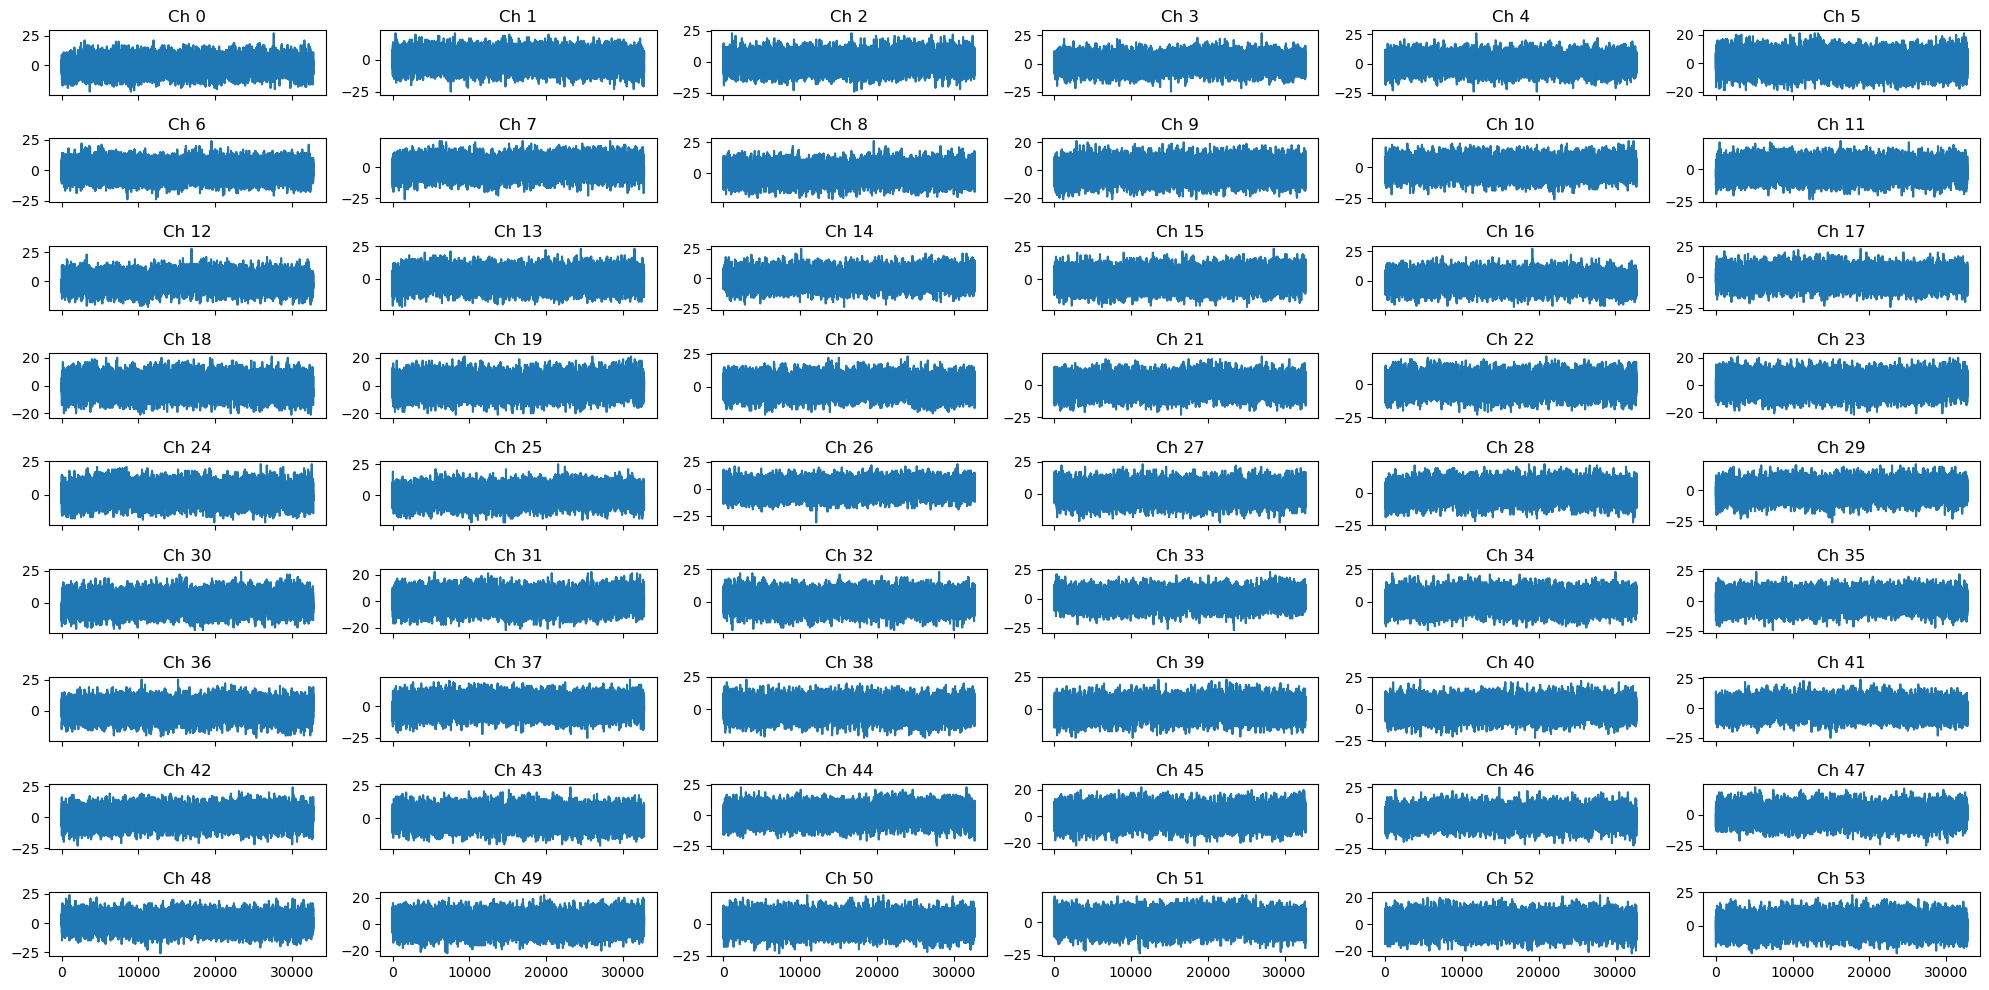

[-0.13284302 -0.37591553  0.01550293  0.30267334  0.261261    0.2697754
 -0.29348755 -0.19515991  0.00674438 -0.36831665 -0.34161377 -0.03497314
 -0.29666138 -0.29278564 -0.03753662 -0.08001709 -0.28500366 -0.3076172
 -0.37194824 -0.1487732   0.287323   -0.3788452  -0.3434143   0.36315918
  0.29516602 -0.23104858  0.3565979   0.3604126   0.36553955 -0.3715515
 -0.13131714  0.02770996 -0.05749512 -0.2572937   0.37667847  0.24124146
  0.03570557 -0.01495361  0.05905151  0.34280396  0.06188965 -0.09298706
 -0.10894775  0.37179565  0.38043213  0.26412964  0.37921143 -0.37625122
  0.3670349   0.37167358 -0.17700195 -0.1355896   0.04428101  0.16067505]
[5.369895  5.3741016 5.374149  5.374251  5.373871  5.375577  5.371582
 5.3704696 5.3712783 5.3744087 5.372831  5.372921  5.3753667 5.3707314
 5.3713245 5.3724055 5.3727727 5.37305   5.3706965 5.373801  5.374591
 5.372788  5.3741894 5.370929  5.372726  5.3726196 5.3746824 5.3756056
 5.3786254 5.3743224 5.376981  5.3726172 5.373085  5.3731823 5.

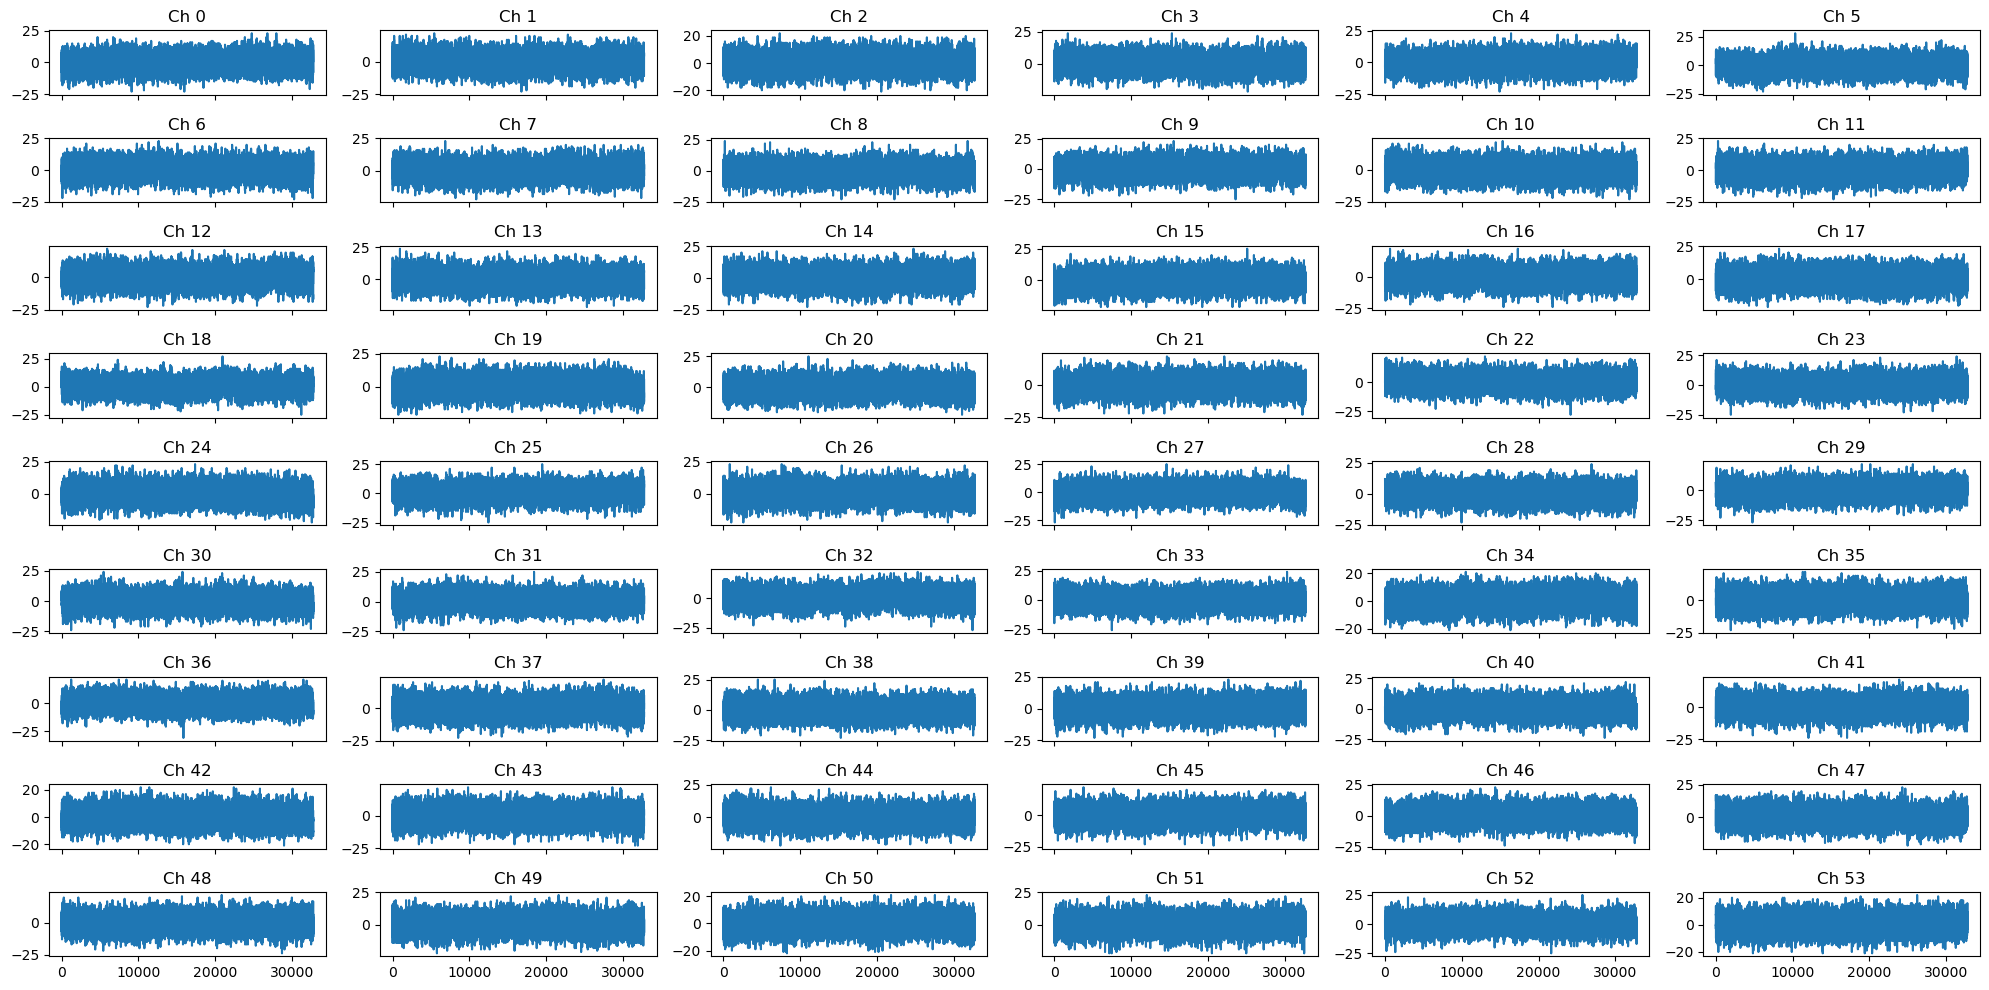

[-3.16528320e-01  2.71057129e-01  3.37219238e-01  3.39111328e-01
 -2.74627686e-01 -3.10638428e-01  1.52191162e-01  1.91192627e-01
 -3.79150391e-01  3.72619629e-01 -3.48266602e-01 -3.43292236e-01
 -9.84191895e-02  4.33044434e-02 -1.31378174e-01 -3.03222656e-01
 -1.20422363e-01  3.41766357e-01  3.78265381e-01  3.03802490e-01
  8.53576660e-02  1.08245850e-01  3.75061035e-01 -2.83966064e-01
  1.04156494e-01  3.61877441e-01  3.76556396e-01 -2.17254639e-01
  1.53900146e-01 -3.01025391e-01 -3.74603271e-01  3.64379883e-01
  3.55072021e-01 -5.67016602e-02  1.72058105e-01  1.78070068e-01
  3.05175781e-04  9.34448242e-02  2.08801270e-01  1.27685547e-01
 -1.02722168e-01  1.47033691e-01  3.11126709e-01 -8.56323242e-02
  7.91320801e-02  6.90612793e-02  1.53198242e-02  2.41394043e-02
 -1.70135498e-01  3.37951660e-01  7.44628906e-03  2.65563965e-01
  2.59033203e-01  2.22351074e-01]
[5.3712144 5.3737583 5.3713126 5.3732786 5.3771386 5.3745656 5.3749943
 5.3721414 5.3764634 5.3772206 5.3724656 5.3737545

In [40]:
n_trace_sets = loaded_traces.shape[0]  # should be 2
n_channels = loaded_traces.shape[1]    # should be 54

channel_means = np.zeros((n_trace_sets, n_channels), dtype=np.float32)
channel_stds = np.zeros((n_trace_sets, n_channels), dtype=np.float32)

for i in range(n_trace_sets):
    trace_set = loaded_traces[i]  # shape: (54, 32768)

    print(f"\n--- Trace Set {i} ---")
    plot_trace_set(trace_set)  # optional visualization

    means = trace_set.mean(axis=-1)  # shape: (54,)
    print(means)
    stds = trace_set.std(axis=-1)    # shape: (54,)
    print(stds)

    channel_means[i] = means
    channel_stds[i] = stds


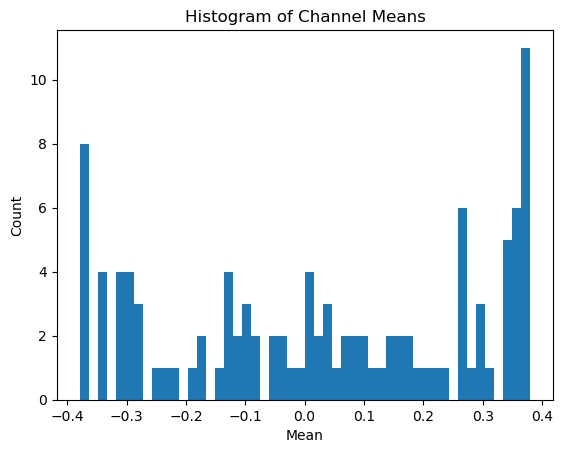

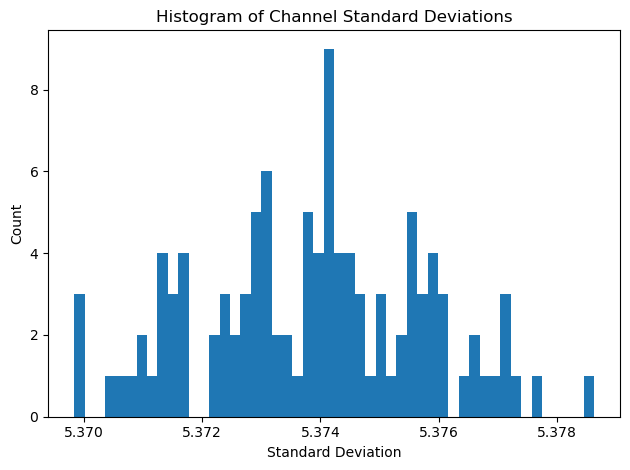

In [41]:
fig1, ax1 = plt.subplots()
ax1.hist(channel_means.flatten(), bins=50)
ax1.set_title("Histogram of Channel Means")
ax1.set_xlabel("Mean")
ax1.set_ylabel("Count")

fig2, ax2 = plt.subplots()
ax2.hist(channel_stds.flatten(), bins=50)
ax2.set_title("Histogram of Channel Standard Deviations")
ax2.set_xlabel("Standard Deviation")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [26]:
trace_set.shape

(1, 54, 32768)

In [28]:
loaded_traces.shape

(2, 1, 54, 32768)

Generating traces:   0%|          | 0/10 [00:00<?, ?it/s]

Generating traces: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


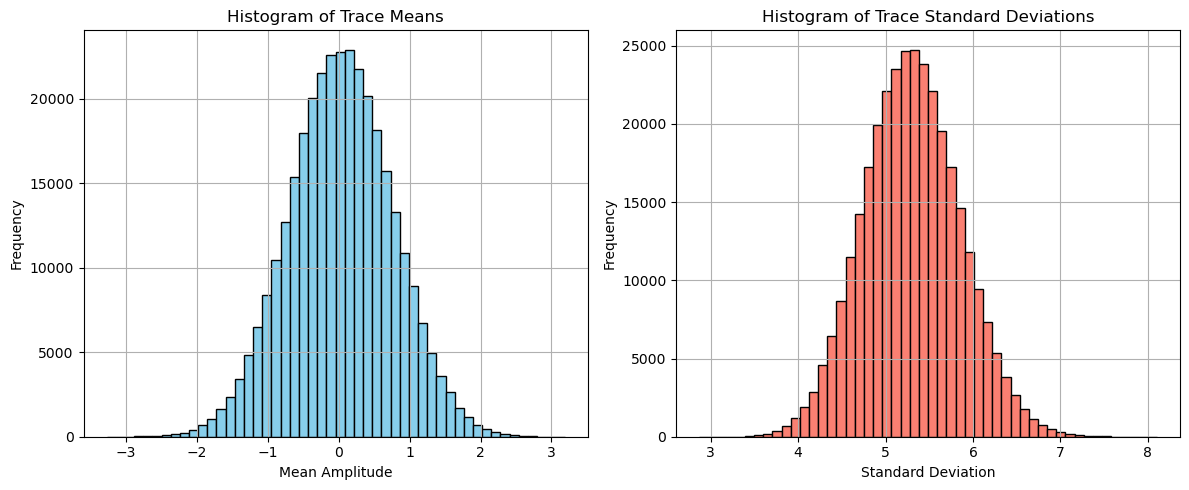

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

energy = 0
n_sets = 10
means = []
stds = []

for _ in tqdm(range(n_sets), desc="Generating traces"):
    trace_batch = ts.generate(
        E=energy,
        x=-40, y=80, z=-1800,
        no_noise=False,
        type_recoil='NR',
        quantize=True,
        phonon_only=False
    )  # shape (54, 32768)

    trace_batch = np.asarray(trace_batch, dtype=np.float32)

    # Compute mean and std for each of the 54 traces in this batch
    batch_means = np.mean(trace_batch, axis=1)  # shape (54,)
    batch_stds = np.std(trace_batch, axis=1)    # shape (54,)

    means.append(batch_means)
    stds.append(batch_stds)

# Convert to arrays: shape (1000, 54)
means = np.stack(means, axis=0)
stds = np.stack(stds, axis=0)

# Plot histograms of flattened data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(means.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Trace Means")
plt.xlabel("Mean Amplitude")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(stds.flatten(), bins=50, color='salmon', edgecolor='black')
plt.title("Histogram of Trace Standard Deviations")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()


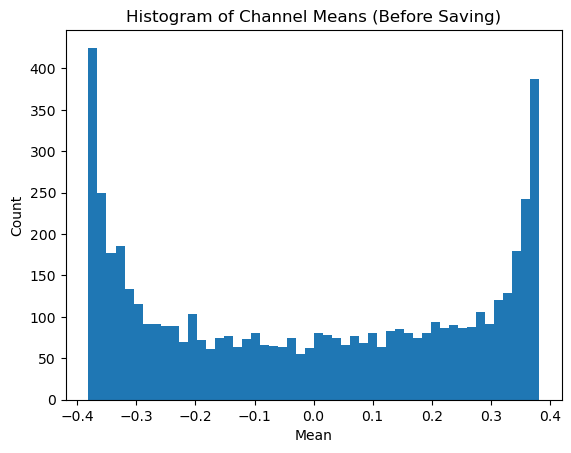

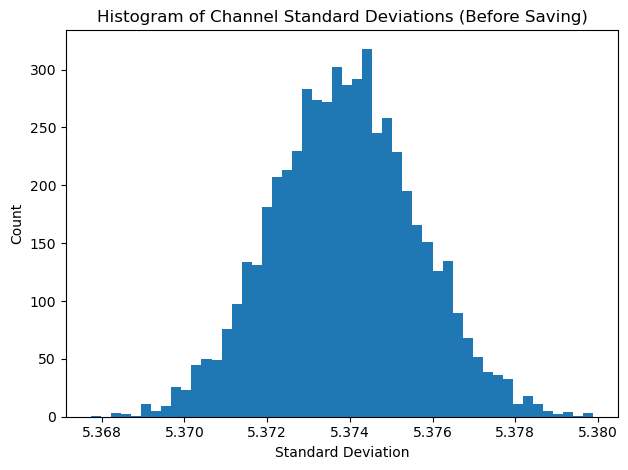

NameError: name 'save_traces_to_zstd' is not defined

In [ ]:
energy = 0
n_sets = 100
all_traces = []
all_means = []
all_stds = []

for _ in range(n_sets):
    trace = ts.generate(
        E=energy,
        x=-40, y=80, z=-1800,
        no_noise=False,
        type_recoil='NR',
        quantize=True,
        phonon_only=False
    ) # simulate single (1, 54, 32768) trace
    trace = np.asarray(trace[0], dtype=np.float16)  # shape: (54, 32768)
    all_traces.append(trace)

    # Convert to float32 for numerical stability in calculations
    trace_f32 = trace.astype(np.float32)
    means = trace_f32.mean(axis=-1)  # shape: (54,)
    stds = trace_f32.std(axis=-1)    # shape: (54,)

    all_means.extend(means)
    all_stds.extend(stds)


# Convert to numpy arrays for histogram plotting
all_means = np.array(all_means)
all_stds = np.array(all_stds)

# Plot histograms
fig1, ax1 = plt.subplots()
ax1.hist(all_means, bins=50)
ax1.set_title("Histogram of Channel Means (Before Saving)")
ax1.set_xlabel("Mean")
ax1.set_ylabel("Count")

fig2, ax2 = plt.subplots()
ax2.hist(all_stds, bins=50)
ax2.set_title("Histogram of Channel Standard Deviations (Before Saving)")
ax2.set_xlabel("Standard Deviation")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()



In [11]:
trace_f32.shape

(54, 32768)

In [12]:
batch_means = np.mean(trace_f32, axis=1)

In [13]:
batch_means.shape

(54,)

In [14]:
batch_means

array([ 0.3553772 ,  0.16851807,  0.37268066,  0.23760986, -0.03347778,
       -0.22958374,  0.21548462,  0.35934448,  0.19128418,  0.24996948,
       -0.05493164, -0.23654175,  0.33706665,  0.00799561, -0.23422241,
        0.27792358,  0.26712036, -0.04470825,  0.37387085,  0.3675232 ,
        0.26538086,  0.29211426,  0.29937744, -0.37548828, -0.3331604 ,
        0.01568604, -0.23535156,  0.09967041, -0.07913208, -0.11898804,
       -0.37490845,  0.2243042 ,  0.16525269, -0.09613037, -0.36343384,
        0.07214355, -0.11456299, -0.37365723,  0.34765625, -0.02194214,
        0.17279053,  0.38134766, -0.1579895 , -0.11880493,  0.21536255,
        0.27011108, -0.3583374 ,  0.28985596,  0.15530396, -0.26782227,
       -0.15493774,  0.3369751 ,  0.37512207, -0.14175415], dtype=float32)

In [15]:
energy = 0
n_sets = 10
means = []
stds = []

for _ in tqdm(range(n_sets), desc="Generating traces"):
    trace_batch = ts.generate(
        E=energy,
        x=-40, y=80, z=-1800,
        no_noise=False,
        type_recoil='NR',
        quantize=True,
        phonon_only=False
    )  # shape (54, 32768)

    trace_batch = np.asarray(trace_batch, dtype=np.float32)

    # Compute mean and std for each of the 54 traces in this batch
    batch_means = np.mean(trace_batch, axis=1)  # shape (54,)
    batch_stds = np.std(trace_batch, axis=1)    # shape (54,)

    means.append(batch_means)
    stds.append(batch_stds)

# Convert to arrays: shape (1000, 54)
means = np.stack(means, axis=0)
stds = np.stack(stds, axis=0)

Generating traces: 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


In [17]:
batch_means.shape

(1, 32768)